In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util

In [2]:
_N = 5
_M = 5
_NEW_VERTICES = 5

_INIT_ATTR_COUNT = 1 # Number of possible attributes for each dimension

_RW_LENGTH = 5 # Length of random walk when adding vertex

_MATCH_THRESH = 0.6

In [3]:
def pick_attr(vtx_iter):
    return np.random.randint(0, _INIT_ATTR_COUNT + vtx_iter)

def num_new_attr(vtx_iter):
    return 1

def has_edge(u, v, attr_dict):
    attr_comp_cnt = min(len(attr_dict[u]), len(attr_dict[v]))
    for a_idx in range(attr_comp_cnt):
        if attr_dict[u][a_idx] != attr_dict[v][a_idx]:
            return False
    return True

def attribute_block_graph(n):
    vtx_set = []
    attr_dict = {}

    for i in range(n):
        vtx = graph.Vertex(0, 0, {0 : 0}, i)
        vtx.data = 0
        attr_dict[vtx] = [ pick_attr(0) ]
        vtx_set.append(vtx)

    G = graph.Graph()
    G.vertices = vtx_set
    
    # Within community
    for u in G.vertices:
        for v in G.vertices:
            if u.vnum == v.vnum:
                continue
            if has_edge(u, v, attr_dict):
                G.add_edge(u, v, 1)

    G.data = attr_dict
    return G

In [4]:
def add_attr_graph_vtx(G, v, rw_len):
    G.data[v] = [ pick_attr(0) ]
    
    # Find vertex with closest homophily value
    in_group_vtxs = [ u for u in G.vertices if G.data[u][0] == G.data[v][0] ]
    
    init_vtx = np.random.choice(in_group_vtxs)
    G.add_edge(v, init_vtx, 1)
    
    # Start random walk
    cur_vtx = init_vtx
    for _ in range(rw_len):
        cur_vtx = np.random.choice(cur_vtx.nbors)
        if (v in cur_vtx.edges) and (cur_vtx in v.edges):
            continue
        if has_edge(v, cur_vtx, G.data):
            G.add_edge(v, cur_vtx, 1)
    G.vertices.append(v)
    return init_vtx

def add_attr_dim(G):
    for v in G.vertices:
        for _ in range(num_new_attr(v.data)):
            G.data[v].append(pick_attr(v.data))
        v.data += 1
        
def filter_edges(G):
    def maintain_edge(u, v, attr_dict):
        attr_comp_cnt = min(len(attr_dict[u]), len(attr_dict[v]))
        num_matching = 0
        for a_idx in range(attr_comp_cnt):
            if attr_dict[u][a_idx] == attr_dict[v][a_idx]:
                num_matching += 1
        return num_matching / attr_comp_cnt >= _MATCH_THRESH
    
    for u in G.vertices:
        for v in u.nbors:
            if not maintain_edge(u, v, G.data):
                G.remove_edge(u, v)

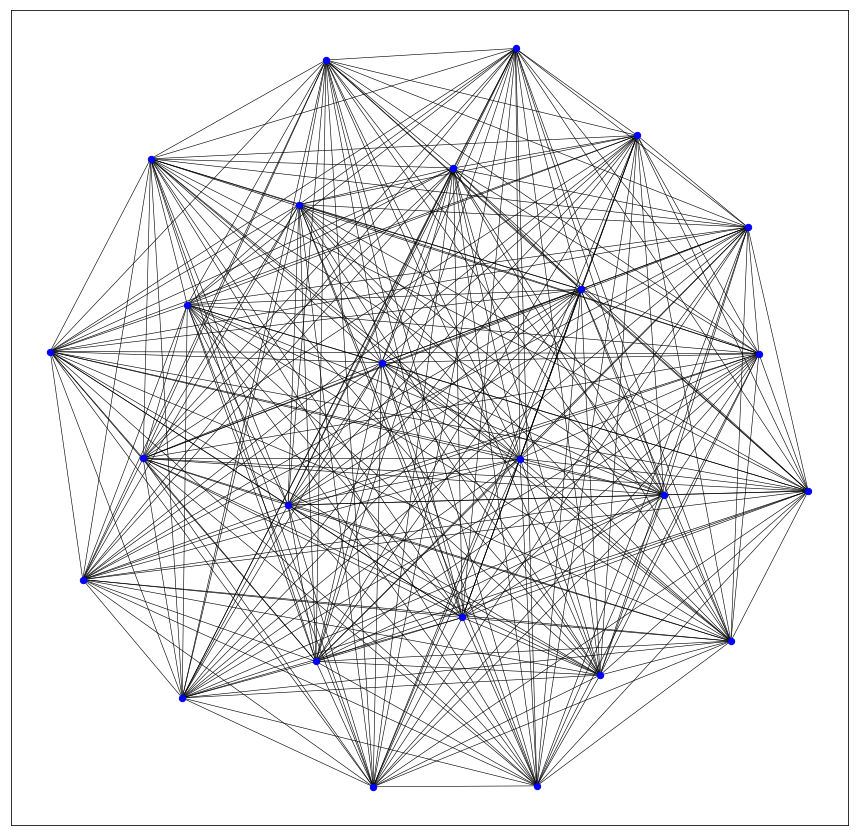

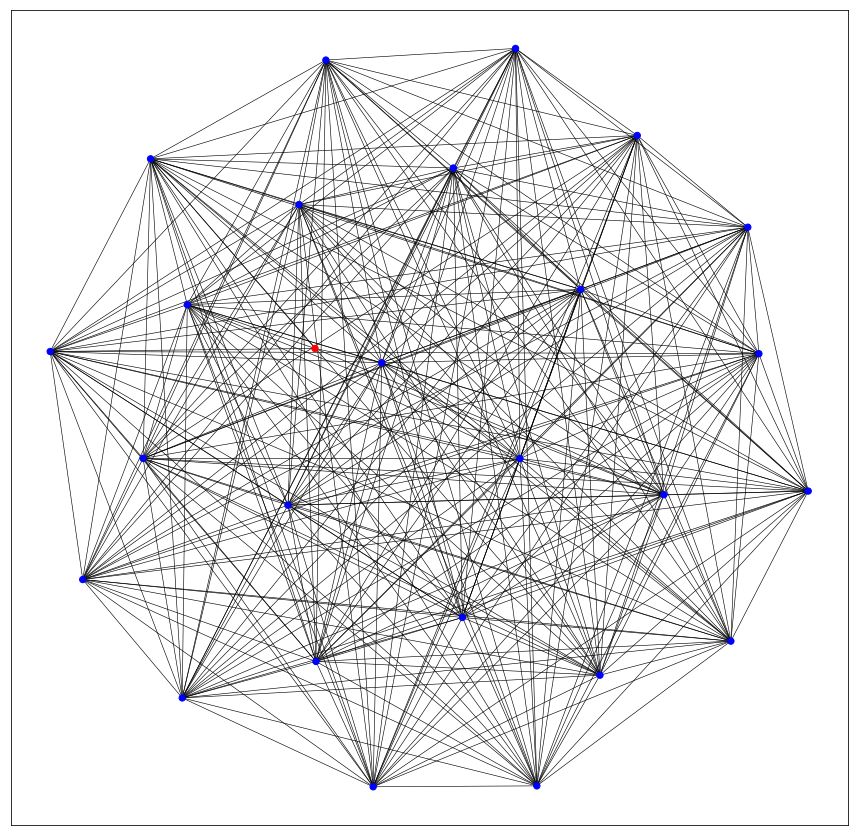

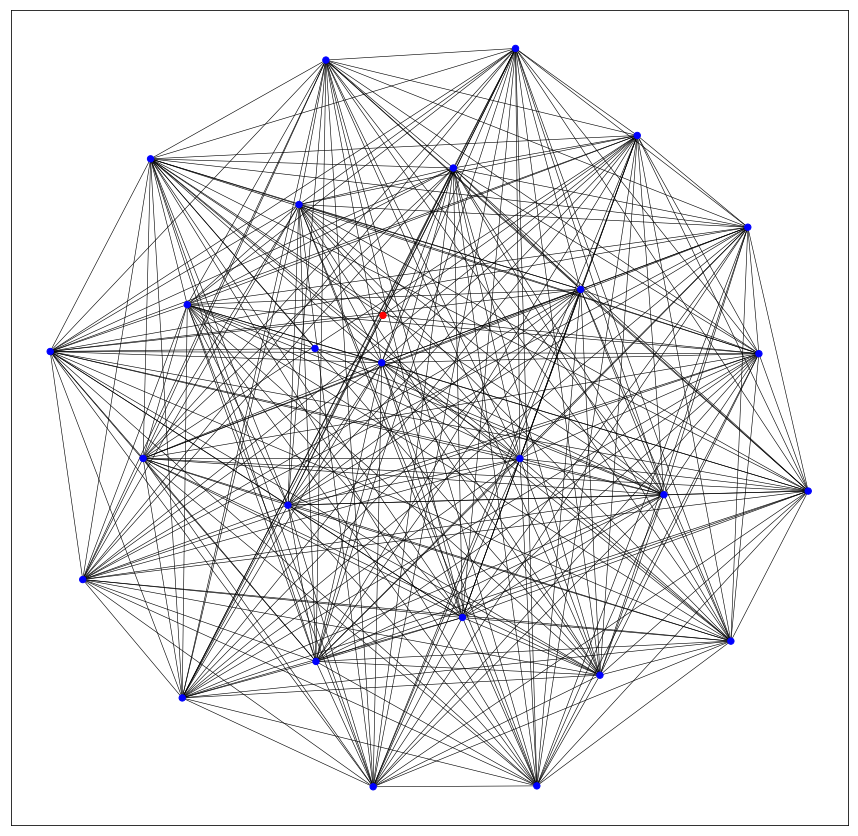

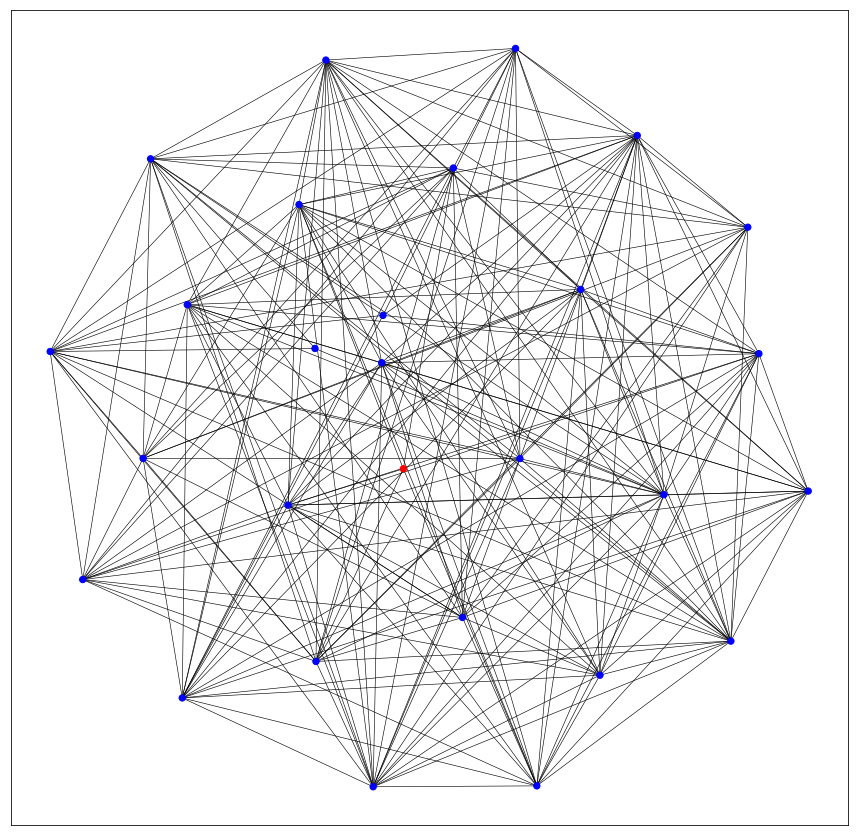

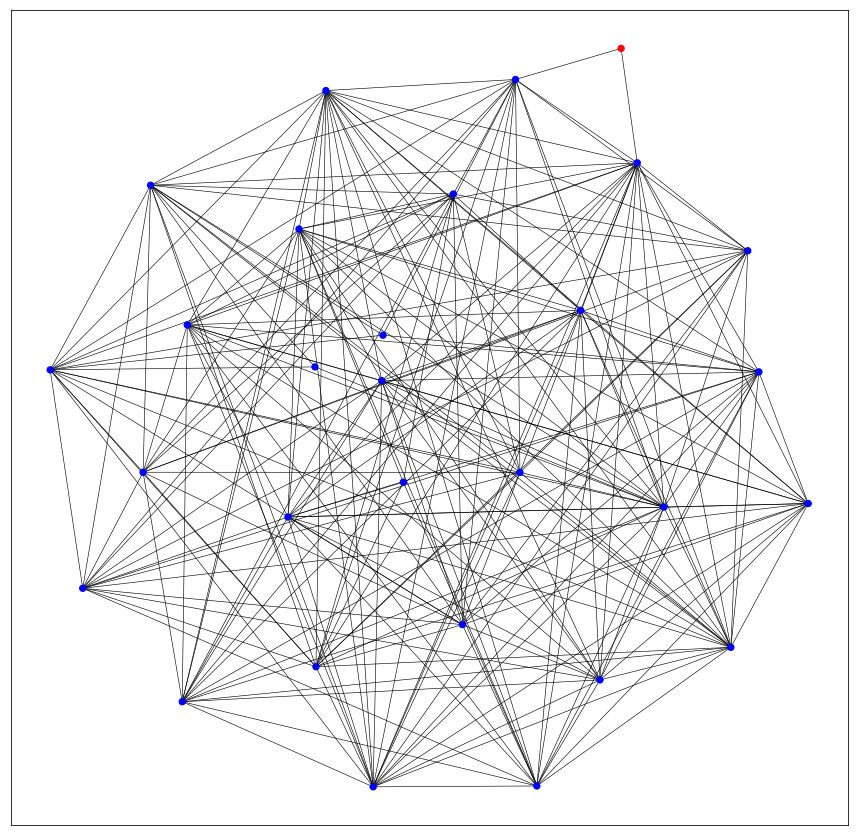

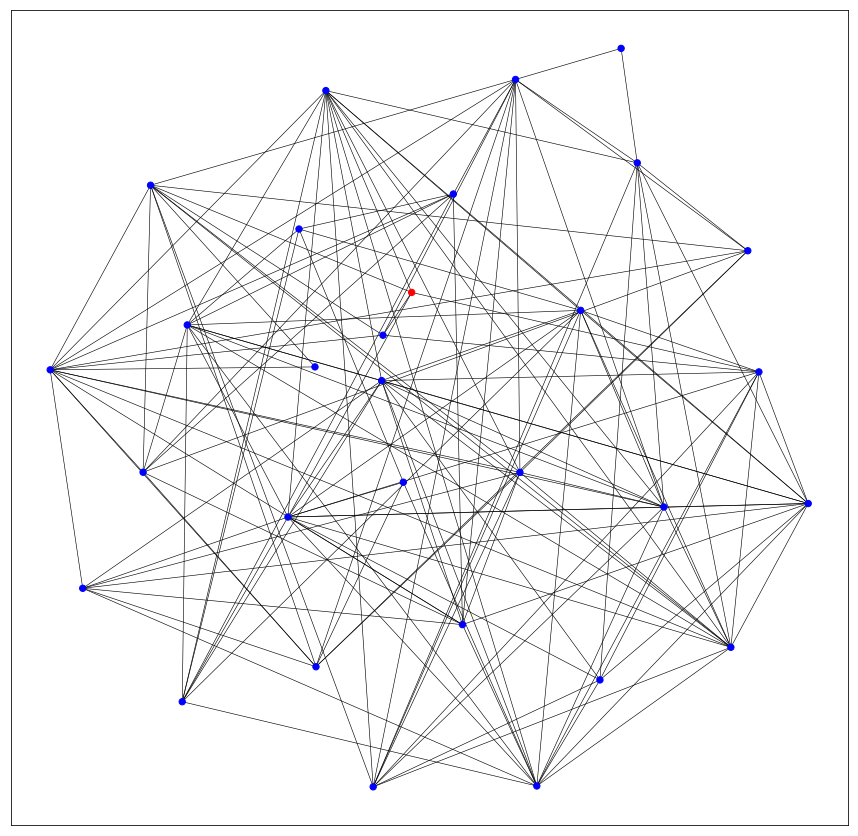

In [5]:
G_attr = attribute_block_graph(_N * _M)
G_attr_nx = gnx.graph_to_nx(G_attr)

G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)

plt.figure(figsize=(15,15))
nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color='b',
                 node_size=40, width=0.6, with_labels=False)

new_vtxs = []

for itr in range(_NEW_VERTICES):
    
    # Add vertex and add dimension to attributes
    nvtx = graph.Vertex(0, 0, {0 : 0}, _N * _M + itr)
    nvtx.data = 0
    init_vtx = add_attr_graph_vtx(G_attr, nvtx, _RW_LENGTH)
    add_attr_dim(G_attr)
    filter_edges(G_attr)
    
    # Graph drawing parameters
    prev_pos = G_attr_vtx_pos
    prev_nodes = G_attr_nx.nodes()
    
    G_attr_nx = gnx.graph_to_nx(G_attr)
    prev_pos[nvtx] = prev_pos[init_vtx]
    nvtx_idx = list(G_attr_nx.nodes()).index(nvtx)
    colors = [ 'b' ] * len(G_attr.vertices)
    colors[nvtx_idx] = 'r'
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx,
                                                     pos=prev_pos, fixed=prev_nodes)
    
    # Draw graph
    plt.figure(figsize=(15,15))
    nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos, node_color=colors,
                     node_size=40, width=0.6, with_labels=None)
    
    new_vtxs.append(nvtx)